## Contents
- [1. Introduction](#1.-Introduction)
- [2. Imports](#2.-Imports)
- [3. Label Data & Train Model](#3.-Label-Data-&-Train-Model)
- [4. Model Prediction](#4.-Model-Prediction)

---
### 1. Introduction
---
To develop an improved object detection model using:
- YOLOv5l
    - Starting on pretrained weights on COCO 2017
    - with YOLOv5 default training data augmentation of:
        - colours: hue (0.015), saturation (0.7), lightness (0.4)
        - image translation (0.1), scale (0.5), flip left-right (0.5) and mosaic (applied)
        - full parameters in hyp.scratch-low.yaml file
<br>
<br>
- Dataset (total 1600 photos)
<br>
<br>
    - Training (total 1200 photos)
        - 200 digitally generated photos of ID cards from Slovakia, Spain and Finland each (total 600)
        - 200 digitally generated photos of passports from Latvia, Russia and Greece each (total 600)
<br>
<br>
    - Validation (total 200 photos)
        - 100 digitally generated photos of ID cards from Estonia
        - 100 digitally generated photos of passports from Serbia
<br>
<br>
    - Test (total 200 photos)
        - 100 digitally generated photos of ID cards from Albania
        - 100 digitally generated photos of passports from Azerbaijan

---
## 1. Imports
---

In [1]:
# direct into the cloned repo
%cd yolov5

import torch
import os
import pandas as pd
# to display images
from IPython.display import Image, clear_output  
from roboflow import Roboflow
import matplotlib.pyplot as plt

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

f:\Edmond\03. Learning\01. Personal github\yolov5


f:\Edmond\03. Learning\01. Personal github\.conda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Using torch 1.13.1+cu117 (NVIDIA GeForce RTX 3060)


---
## 2. Label Data & Train Model
---
- using train dataset (Finland, Greece, Russia, Slovak Republic, Serbia, Latvia) 
- and val dataset (Spain, Estonia)

In [2]:
# set up environment to download dataset from roboflow
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [3]:
# download labelled dataset from roboflow
rf = Roboflow(api_key="MY API KEY")  # removed API details
project = rf.workspace("MY WORK SPACE").project("id-card-passport-detection")  # removed workspace details
dataset = project.version(25).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/id-card-passport-detection-25 in yolov5pytorch:: 100%|██████████| 3212/3212 [00:00<00:00, 4424.68it/s]


In [ ]:
# baseline: transfer learn using YOLOv5l model from pretrained weights on COCO 2017val dataset, with no freezing
!python train.py --img 640 --batch 8 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5l.pt --cache  # output cell cleared due to very long printout, disrupting readability

display train vs val losses

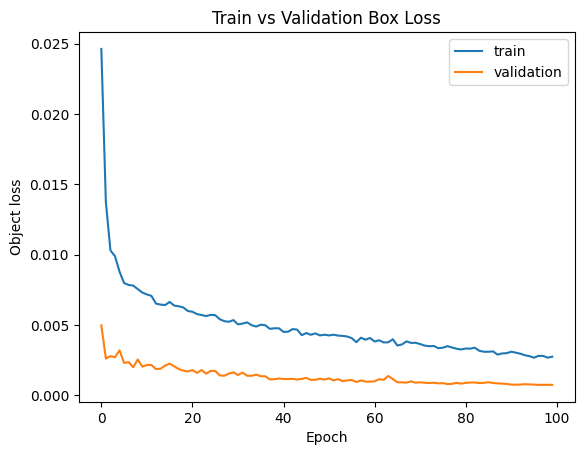

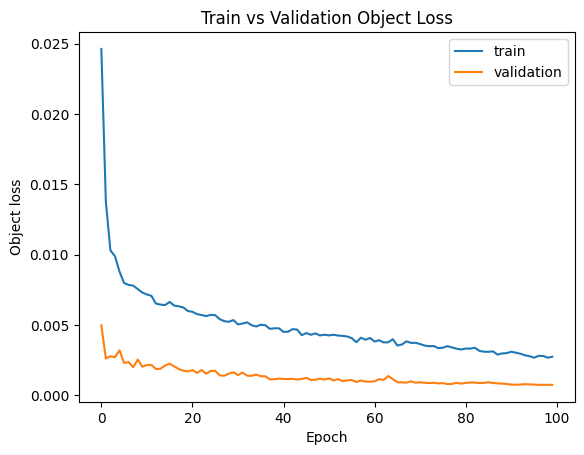

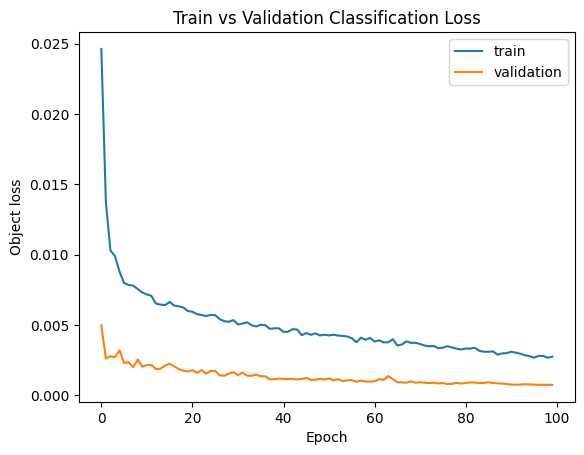

In [5]:
results = pd.read_csv("runs/train/exp19/results.csv")
x = results.iloc[:,0]
y_train_box = results.iloc[:,1]
y_val_box = results.iloc[:,8]
y_train_obj = results.iloc[:,2]
y_val_obj = results.iloc[:,9]
y_train_ls = results.iloc[:,3]
y_val_cls = results.iloc[:,10]

# plot train vs val box loss
plt.plot(x, y_train_obj, label='train')
plt.plot(x, y_val_obj, label = 'validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Object loss')
plt.title('Train vs Validation Box Loss')
plt.show()

# plot train vs val object loss
plt.plot(x, y_train_obj, label='train')
plt.plot(x, y_val_obj, label = 'validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Object loss')
plt.title('Train vs Validation Object Loss')
plt.show()

# plot train vs val classification loss
plt.plot(x, y_train_obj, label='train')
plt.plot(x, y_val_obj, label = 'validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Object loss')
plt.title('Train vs Validation Classification Loss')
plt.show()

In [6]:
# Load tensorboard to log runs, compare results between runs
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 15736), started 1 day, 5:10:36 ago. (Use '!kill 15736' to kill it.)

Analysis:
- the training loss is higher than validation loss, indicating that there is more variation in sample data in the training dataset compared to the validation dataset
- comparing improved model 1 vs this model's performance:
    - this model has a lower training loss than improved model 1, despite having the same augmented data parameters. This is logical as this model has 2x more training data than improved model 1.
    - this model also has a lower validation loss than improved model 1 (except for object loss). This is also due to the increased volume of training data compared to improved model 1.

---
## 3. Model prediction
---
- on test dataset (Albania, Azerbaijan)

In [ ]:
# run inference with trained weights
!python detect.py --weights runs/train/exp19/weights/best.pt --img 640 --conf 0.7 --iou 0.5 --augment --source {dataset.location}/test/images  # output cell cleared due to very long printout, disrupting readability

Analysis of test:
- correctly identified:
    - 96 ID cards
    - 100 passports
<br>
<br>
- wrongly identified:
    - 1 ID cards, wrongly identified as passports
    - 3 ID cards, wrongly identified as background
<br>
<br>
- this model has the best prediction accuracy thus far. However, this model has a weaker capability in identifying objects (due to its error in identifying 2 ID cards as background) than improved model 1 - as shown by its higher validation object loss.

display predicted images (commented out due to long printout)

In [ ]:
# display predicted images
# import glob
# from IPython.display import Image, display

# for imageName in glob.glob('runs/detect/exp4/*.jpg'): #assuming JPG
#     display(Image(filename=imageName))
#     print("\n")